<a href="https://colab.research.google.com/github/kuanhuang54/Machine-Learning/blob/main/3_Dress_Types_Prediction.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Dress Types - PyTorch
Design and train a basic neural network on the FashionMNIST dataset
# Kuan Huang

In [20]:
# import the necessary libraries
import math
import torch
from torch.utils.data import DataLoader #Dataset
from torchvision.transforms import Compose, ToTensor
from torchvision import datasets, transforms
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from ipywidgets import widgets, interact, Layout

In [21]:
# displays output inline
%matplotlib inline

In [22]:
# train model on a hardware accelerator like the GPU if it is available, otherwise continue to use the CPU
for index in range(torch.cuda.device_count()):
  print(torch.cuda.get_device_properties(index))

# Data Preprocessing

In [23]:
# normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# use FashionMNIST dataset published by Zalando Research
data_train = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor()) # =Compose([ToTensor()])
data_test = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor()) # =Compose([ToTensor()])

# set the batch size to 64
batch = 64
load_train = DataLoader(data_train, batch_size=batch, shuffle=True)
load_test = DataLoader(data_test, batch_size=batch, shuffle=True)

In [24]:
# 60,000 training images, each image is a grayscale image with size 28x28 pixels
# 10,000 testing images, each image is a grayscale image with size 28x28 pixels
data_train.data.shape, data_train.targets.shape, data_train.targets.bincount(), data_test.data.shape, data_test.targets.shape, data_test.targets.bincount()

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [25]:
# ten categories from 0 to 9
data_train.classes, data_test.classes

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

###From the data source of Fashion MNIST we can see that the images have been already preprocessed to PIL images. (model ='L', that means only the Luminance of images is stored, or let's say they are grayscaled)

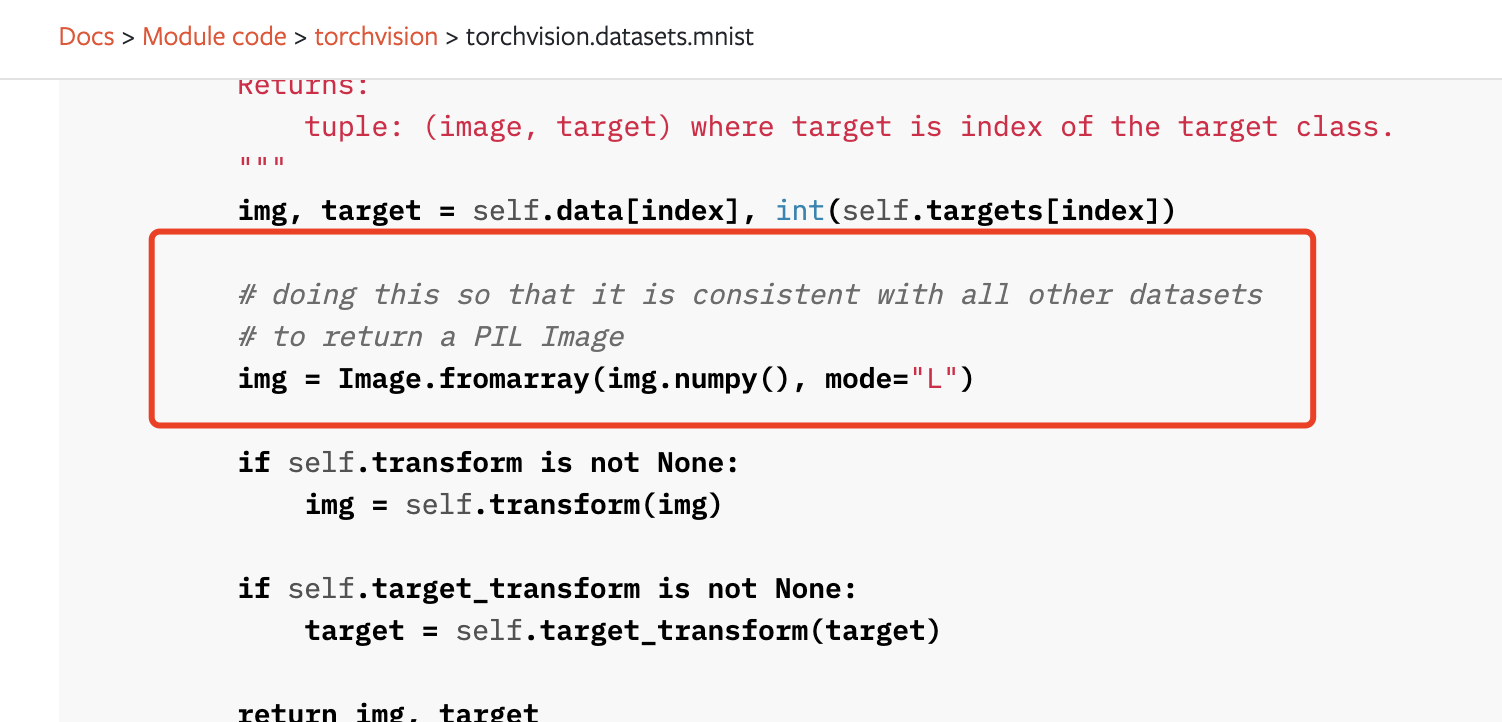

In [26]:
# We don't need to scale the training and testing data sets here
# Because the data source of Fashion MNIST has already process the images to PIL.
'''
# scale the values between 0 and 1 for both training and testing sets
data_train.data = data_train.data / 255.0
data_test.data = data_test.data / 255.0
'''

'\n# scale the values between 0 and 1 for both training and testing sets\ndata_train.data = data_train.data / 255.0\ndata_test.data = data_test.data / 255.0\n'

# Training Set

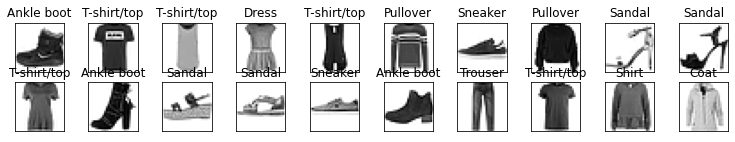

In [27]:
# plot a grid of images with titles of correct names and labels of predicted names
def plot(images, labels, predictions=None):
  # create a grid with 10 columns
  n_cols = min(10, len(images))
  n_rows = math.ceil(len(images) / n_cols)
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols + 3, n_rows))
  if predictions is None:
    predictions = [None] * len(labels)
  for index, (x, y_true, y_pred) in enumerate(zip(images, labels, predictions)):
    ax = axes.flat[index]
    ax.imshow(x, cmap=plt.cm.binary)
    ax.set_title(data_train.classes[y_true])
    if y_pred is not None:
      ax.set_xlabel(data_train.classes[y_pred])
    ax.set_xticks([])
    ax.set_yticks([])
# plot first 20 images
plot(data_train.data[:20], data_train.targets[:20])

# Model in PyTorch

In [28]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256) # Input size = 28*28, apply linear transformation to 256
        self.fc2 = nn.Linear(256, 128) # apply linear transformation to 128
        self.fc3 = nn.Linear(128, 64) # apply linear transformation to 64
        self.fc4 = nn.Linear(64, 10) # apply linear transformation to output, output size = 10
        
    def forward(self, x):
        # make sure input tensor is flattened into 784 
        x = x.view(x.shape[0], -1)
        
        # apply the rectified linear unit function element-wise
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1) 
        
        return x

In [29]:
# define the model
model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


##Training Set

In [30]:
# train the model
torch.manual_seed(20742)

# As we are using Adam Optimization Algorithm, 3e-4 is the best learning rate for Adam, hands down.
# Reference: https://www.jeremyjordan.me/nn-learning-rate/#:~:text=So%20how%20do%20we%20find,rate%20for%20Adam%2C%20hands%20down.
learning_rate = 0.0003

optimizer = optim.Adam(model.parameters(), lr=learning_rate) # implement Adam algorithm with learning rate
# another optimizer: optimizer = optim.SDG(model.parameters(), lr=learning_rate)
#error = nn.CrossEntropyLoss() # this criterion computes the cross entropy loss between input and target
error = nn.CrossEntropyLoss()
# Cross Entropy is usually better than square errors

epochs = 15
for epoch in range(epochs):
  running_loss = 0

  # go through all the images in training set
  for images, labels in load_train:
    optimizer.zero_grad() # training pass
    #already flattened image in the neural network model, so we don't need to flatten image here
    #train = images.view(images.shape[0], -1) # flatten image into a 784 vector
    outputs = model(images)
    loss = error(outputs, labels)
    loss.backward() # learn by backpropagation
    optimizer.step() # optimize weights
    running_loss += loss.item()
  else:
    total = 0
    correct = 0
    for images, labels in load_train:
      #already flattened image in the neural network model, so we don't need to flatten image here
      #train = images.view(images.shape[0], -1) # flatten image into a 784 vector
      outputs = model(images)
      predictions = torch.max(outputs, 1)[1]
      correct += (predictions == labels).sum()
      total += len(labels)
    print(f'Epoch {epoch + 1}/{epochs} - loss: {running_loss / total} - accuracy: {correct / total}')

Epoch 1/15 - loss: 0.010528137834121784 - accuracy: 0.8415666818618774
Epoch 2/15 - loss: 0.006764841891825199 - accuracy: 0.8579999804496765
Epoch 3/15 - loss: 0.006019814424713453 - accuracy: 0.8725500106811523
Epoch 4/15 - loss: 0.005561156997581323 - accuracy: 0.8737000226974487
Epoch 5/15 - loss: 0.005198416221017639 - accuracy: 0.8837166428565979
Epoch 6/15 - loss: 0.004913515706484516 - accuracy: 0.8913499712944031
Epoch 7/15 - loss: 0.004697643660008907 - accuracy: 0.8985333442687988
Epoch 8/15 - loss: 0.004491193372011185 - accuracy: 0.8964499831199646
Epoch 9/15 - loss: 0.0042891290565331775 - accuracy: 0.9078166484832764
Epoch 10/15 - loss: 0.004096097901463509 - accuracy: 0.9070333242416382
Epoch 11/15 - loss: 0.003974897768845161 - accuracy: 0.9125000238418579
Epoch 12/15 - loss: 0.003839567335198323 - accuracy: 0.9069499969482422
Epoch 13/15 - loss: 0.0037325171606615187 - accuracy: 0.9168333411216736
Epoch 14/15 - loss: 0.003583409900466601 - accuracy: 0.9209499955177307

## Testing Set

In [31]:
count = 0
correct = 0
for images, labels in load_test:
  test = images.view(images.shape[0], -1) # flatten image into a 784 vector
  with torch.no_grad():
    probs = model(test)
    preds = torch.max(probs, 1)[1]
  correct += (preds == labels).sum()
  count += len(labels)
print(f'Tested {count} images - accuracy: {correct / count}')

Tested 10000 images - accuracy: 0.8860999941825867


### To avoid overfitting, dropout is applied to the modified model. Let's see if there's any improvement with the dropout.

# Modified Model with dropout

In [32]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256) # Input size = 28*28, apply linear transformation to 256
        self.fc2 = nn.Linear(256, 128) # apply linear transformation to 128
        self.fc3 = nn.Linear(128, 64) # apply linear transformation to 64
        self.fc4 = nn.Linear(64, 10) # apply linear transformation to output, output size = 10
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened into 784 
        x = x.view(x.shape[0], -1)
        
        # apply the rectified linear unit function element-wise
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output does not need to dropout
        x = F.log_softmax(self.fc4(x), dim=1) 
        
        return x

In [33]:
# define the model
model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


##Training Set

In [34]:
# train the model
torch.manual_seed(20742)

# set the learning rate.
learning_rate = 0.0003

optimizer = optim.Adam(model.parameters(), lr=learning_rate) # implement Adam algorithm with learning rate
# another optimizer: optimizer = optim.SDG(model.parameters(), lr=learning_rate)
#error = nn.CrossEntropyLoss() # this criterion computes the cross entropy loss between input and target
error = nn.CrossEntropyLoss()
# Cross Entropy is usually better than square errors

epochs = 15
for epoch in range(epochs):
  running_loss = 0

  # go through all the images in training set
  for images, labels in load_train:
    optimizer.zero_grad() # training pass
    #already flattened image in the neural network model, so we don't need to flatten image here
    #train = images.view(images.shape[0], -1) # flatten image into a 784 vector
    outputs = model(images)
    loss = error(outputs, labels)
    loss.backward() # learn by backpropagation
    optimizer.step() # optimize weights
    running_loss += loss.item()
  else:
    total = 0
    correct = 0
    for images, labels in load_train:
      #already flattened image in the neural network model, so we don't need to flatten image here
      #train = images.view(images.shape[0], -1) # flatten image into a 784 vector
      outputs = model(images)
      predictions = torch.max(outputs, 1)[1]
      correct += (predictions == labels).sum()
      total += len(labels)
    print(f'Epoch {epoch + 1}/{epochs} - loss: {running_loss / total} - accuracy: {correct / total}')

Epoch 1/15 - loss: 0.012486301170289517 - accuracy: 0.8147833347320557
Epoch 2/15 - loss: 0.0076493915441135565 - accuracy: 0.8420833349227905
Epoch 3/15 - loss: 0.006609428967038791 - accuracy: 0.8599333167076111
Epoch 4/15 - loss: 0.006080907190839449 - accuracy: 0.8692499995231628
Epoch 5/15 - loss: 0.0057185356269280115 - accuracy: 0.8689666390419006
Epoch 6/15 - loss: 0.005479419208069642 - accuracy: 0.8745499849319458
Epoch 7/15 - loss: 0.005220034166177114 - accuracy: 0.8856333494186401
Epoch 8/15 - loss: 0.00504149160074691 - accuracy: 0.8890666961669922
Epoch 9/15 - loss: 0.004875167907277743 - accuracy: 0.8900166749954224
Epoch 10/15 - loss: 0.004726576882104079 - accuracy: 0.8939833045005798
Epoch 11/15 - loss: 0.0045959579174717265 - accuracy: 0.8994333148002625
Epoch 12/15 - loss: 0.004436762186388174 - accuracy: 0.9000833630561829
Epoch 13/15 - loss: 0.004362633679558833 - accuracy: 0.902816653251648
Epoch 14/15 - loss: 0.00427849236279726 - accuracy: 0.9048666954040527
E

## Testing Set

In [35]:
count = 0
correct = 0
for images, labels in load_test:
  test = images.view(images.shape[0], -1) # flatten image into a 784 vector
  with torch.no_grad():
    probs = model(test)
    preds = torch.max(probs, 1)[1]
  correct += (preds == labels).sum()
  count += len(labels)
print(f'Tested {count} images - accuracy: {correct / count}')

Tested 10000 images - accuracy: 0.8752999901771545


### It turns that the previous model is not overfitting and thus dropout is unnecessary. Dropout makes the accuracy lower.

# Application

In [36]:
img_idx_slider = widgets.IntSlider(value=0, min=0, max=len(data_test) - 1, description='Image index', layout=Layout(width='100%'))
@interact(index=img_idx_slider)
def visualize_prediction(index=0):
  image, label = data_test[index]
  test = image.view(1, 28 * 28)
  with torch.no_grad():
    probs = model(test)
    #As in the model the output has been logged, so it would be a negative number
    #In order to show the result in the bar chart, it has to be positve.
    probs = F.softmax(probs, dim=1)
  pred = probs.argmax(1).item()
  fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  ax1.imshow(data_test.data[index], cmap=plt.cm.binary)
  ax1.set_title(f'Label: {data_test.classes[data_test.targets[index]]}')
  ax1.set_xlabel(f'Predict: {data_test.classes[pred]}')
  ax1.set_ylabel('Pixel location index')
  ax1.xaxis.tick_top()
  ax1.tick_params(axis='x', labelrotation=90)
  ax2.bar(x=data_test.classes, height=probs[0]*100)
  # deleted the unnecessay sticks here.
  ax2.set_xlabel('Prediction')
  ax2.set_ylabel('Probability (%)')
  ax2.set_ylim(0, 100)
  ax2.tick_params(axis='x', labelrotation=90)

interactive(children=(IntSlider(value=0, description='Image index', layout=Layout(width='100%'), max=9999), Ou…